# Demonstrating Vector Variables in PyMC

This tutorial shows how to work with **vector-valued random variables** in PyMC,
using a simple example with several groups of data that share a common
structure but have different means (and optionally different standard
deviations).

We will:

1. Simulate data from multiple groups.  
2. Build a PyMC model with vector parameters `mu` (means) and `sigma`.  
3. Use indexing to connect each observation to the right group parameter.  
4. Sample from the posterior and inspect the results.



## 1. Setup

We start by importing the libraries we need and fixing a random seed for
reproducibility.

In [1]:
import arviz as az
import numpy as np

import pymc as pm

RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
import os

# Configure PyTensor to use g++ compiler if available, otherwise suppress warning
import pytensor

# Try to find g++ compiler
gxx_paths = [
    r"C:\Users\mrcle\miniconda3\Library\bin\x86_64-w64-mingw32-g++.exe",
    "g++",  # Try system g++ if in PATH
]

gxx_found = None
for path in gxx_paths:
    if path == "g++":
        # Check if g++ is in PATH
        import shutil

        if shutil.which("g++"):
            gxx_found = "g++"
            break
    elif os.path.exists(path):
        gxx_found = path
        break

if gxx_found:
    pytensor.config.cxx = gxx_found
    print(f"PyTensor configured to use: {gxx_found}")
else:
    # Suppress warning if compiler not found
    pytensor.config.cxx = ""
    print(
        "g++ compiler not found. PyTensor will use Python fallback (slower but works fine for examples)."
    )

## 2. Simulate grouped data

We create:

- `num_groups`: how many groups we have.  
- `group_size`: how many observations per group.  
- `sigma_true`: shared standard deviation of the observation noise.  
- `mu_true`: a vector of true group means (used only to generate fake data).

We then build:

- `data`: stacked observations from all groups.  
- `data_labels`: an integer label (0, 1, ..., `num_groups-1`) telling us
  which group each observation belongs to.

In [3]:
num_groups = 5
group_size = 200
sigma_true = 1.0

# True means for each group (just for simulation, not known to the model)
mu_true = rng.normal(loc=np.linspace(-2, 2, num_groups), scale=0.5, size=num_groups)

# Simulate data: for each group, draw `group_size` points
data_per_group = [rng.normal(loc=mu, scale=sigma_true, size=group_size) for mu in mu_true]
data = np.concatenate(data_per_group)

# Integer labels telling which group each observation belongs to
data_labels = np.concatenate(
    [np.full(group_size, group_id) for group_id in range(num_groups)]
).astype(int)

data[:10], data_labels[:10]

(array([-1.91745688, -3.13102432, -1.95260845, -2.81115613, -2.81694979,
        -2.39739336, -4.02049108, -1.30239457, -3.16565035, -1.49429126]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

`data` is a 1D array of length `num_groups * group_size`.

`data_labels` is a 1D integer array of the same length, where each element is
the group index (from 0 to `num_groups - 1`) for the corresponding observation.

---

## 3. Building the PyMC model with vector variables

Key idea: instead of defining separate scalar parameters for each group, we
define *vector-valued* parameters:

- `mu`: a length-`num_groups` vector of group means.  
- `sigma`: a length-`num_groups` vector of group standard deviations
  (or we could use a single shared `sigma` if we prefer).

Then we use **indexing** with `data_labels` to pick the right parameter for
each observation.

In [4]:
with pm.Model() as model:
    # Vector of group means
    mu = pm.Normal("mu", mu=0.0, sigma=10.0, shape=num_groups)

    # Vector of group standard deviations (half-normal prior)
    sigma = pm.HalfNormal("sigma", sigma=2.0, shape=num_groups)

    # The likelihood: for each observation i,
    #   data[i] ~ Normal(mu[data_labels[i]], sigma[data_labels[i]])
    likelihood = pm.Normal(
        "y",
        mu=mu[data_labels],
        sigma=sigma[data_labels],
        observed=data,
    )

model

   mu ~ Normal(0, 10)
sigma ~ HalfNormal(0, 2)
    y ~ Normal(f(mu), f(sigma))

Notes:

- `mu[data_labels]` creates a 1D array where each element is the mean
  corresponding to the group of that observation.  
- Similarly for `sigma[data_labels]`.  
- This is the crucial **vectorization trick** that avoids explicit Python loops.

---

## 4. Sampling from the posterior

Now we run MCMC to obtain samples from the posterior distribution of the
parameters.

In [5]:
with model:
    idata = pm.sample(
        draws=300,
        tune=300,
        chains=1,
        cores=1,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, sigma]


Output()

Sampling 1 chain for 300 tune and 300 draw iterations (300 + 300 draws total) took 409 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


## 5. Inspecting the results

We compare the posterior means of `mu` and `sigma` to the true values used to
simulate the data.

In [6]:
print("Posterior summary for mu:")
display(az.summary(idata, var_names=["mu"]))

print("\nPosterior summary for sigma:")
display(az.summary(idata, var_names=["sigma"]))

arviz - WARNING - Shape validation failed: input_shape: (1, 300), minimum_shape: (chains=2, draws=4)


Posterior summary for mu:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],-2.410,0.063,-2.548,-2.310,0.002,0.004,625.0,218.0,NaN
mu[1],-1.208,0.079,-1.355,-1.055,0.004,0.005,569.0,99.0,NaN
mu[2],0.620,0.081,0.475,0.779,0.004,0.006,515.0,164.0,NaN
mu[3],1.078,0.082,0.905,1.203,0.003,0.005,743.0,191.0,NaN
mu[4],2.551,0.067,2.425,2.671,0.003,0.003,503.0,254.0,NaN


arviz - WARNING - Shape validation failed: input_shape: (1, 300), minimum_shape: (chains=2, draws=4)



Posterior summary for sigma:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[0],0.919,0.045,0.834,0.999,0.002,0.003,696.0,201.0,NaN
sigma[1],1.087,0.056,0.993,1.197,0.002,0.003,743.0,227.0,NaN
sigma[2],1.042,0.050,0.942,1.134,0.002,0.004,650.0,208.0,NaN
sigma[3],1.042,0.057,0.928,1.143,0.002,0.004,664.0,213.0,NaN
sigma[4],0.971,0.054,0.881,1.072,0.002,0.003,612.0,188.0,NaN


### Optional: visual comparison

If `matplotlib` is available, we can visualize the posterior mean of each
parameter against the true (simulated) value.

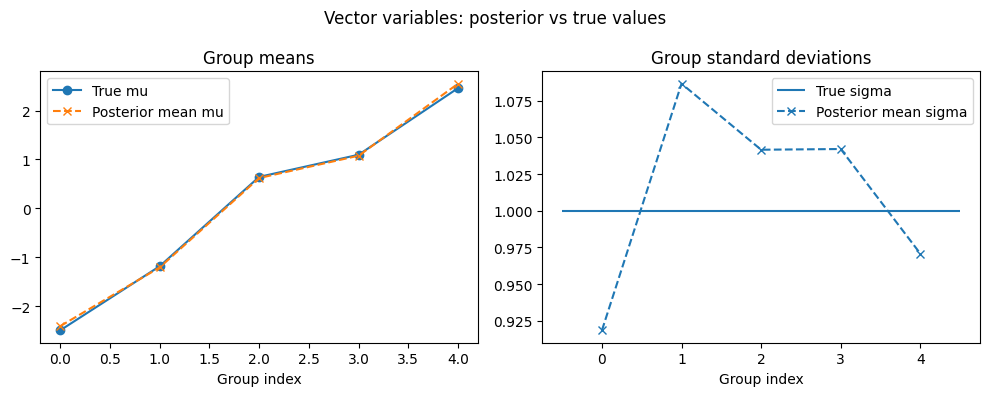

In [7]:
import matplotlib.pyplot as plt

post_mu_means = idata.posterior["mu"].mean(dim=("chain", "draw")).values
post_sigma_means = idata.posterior["sigma"].mean(dim=("chain", "draw")).values

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot for mu
axes[0].plot(mu_true, "o-", label="True mu")
axes[0].plot(post_mu_means, "x--", label="Posterior mean mu")
axes[0].set_title("Group means")
axes[0].set_xlabel("Group index")
axes[0].legend()

# Plot for sigma
axes[1].hlines(sigma_true, xmin=-0.5, xmax=num_groups - 0.5, label="True sigma")
axes[1].plot(post_sigma_means, "x--", label="Posterior mean sigma")
axes[1].set_title("Group standard deviations")
axes[1].set_xlabel("Group index")
axes[1].legend()

fig.suptitle("Vector variables: posterior vs true values")
plt.tight_layout()
plt.show()

## 6. Takeaways

- You can represent many similar parameters at once by using **vector-valued
  random variables** with a `shape` argument.  
- Use integer labels (like `data_labels`) to index into these vectors and
  connect each observation to the right group parameter.  
- This pattern generalizes to more complex models, including hierarchical
  models where the vector parameters themselves have hyperpriors.

You can now adapt this pattern to your own models whenever you have many
groups (or categories) that share the same likelihood form but different
parameters.

## Watermark


In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sat Nov 22 2025

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.7.0

pytensor: 2.35.1
xarray  : 2025.11.0

matplotlib: 3.10.7
pymc      : 5.26.1
arviz     : 0.22.0
numpy     : 2.3.5
debugpy   : 1.8.17
ipykernel : 7.1.0

Watermark: 2.5.0

